# Predicting tip percentage
- Attempting to predict the tip percentage (tip_amount/fare_amount) from the available data such as trip distance, pickup locations, etc
- Anaconda python2 environment

In [1]:
!pip install pygeohash

You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygeohash as gh
%matplotlib inline

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble
from sklearn.metrics import accuracy_score, roc_auc_score

C:\Users\msleo\anaconda2\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
df = pd.read_csv('data.csv')

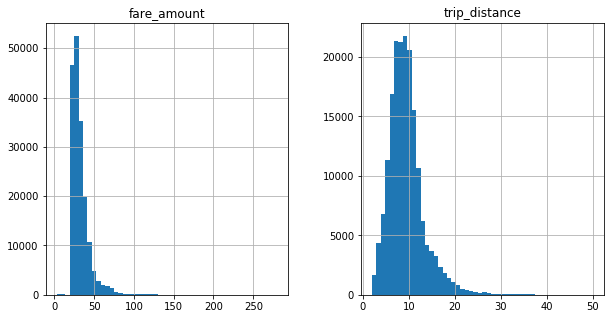

In [5]:
# Remove those outliers with very low or very high trip_distance or fare_amount
df_filtered = df[(df['trip_distance'] >= 2) & (df['trip_distance'] <= 50) & (df['fare_amount'] >= 3) & (df['fare_amount'] <=300)].copy()
df_filtered[['trip_distance','fare_amount']].hist(figsize = (10,5), bins=50);

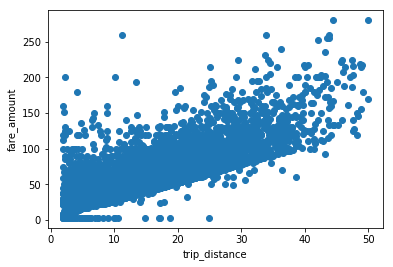

In [6]:
# Check the correlation between trip_distance and fare_amount to see if outliers are removed
plt.scatter(df_filtered['trip_distance'], df_filtered['fare_amount'])
plt.xlabel('trip_distance')
plt.ylabel('fare_amount');

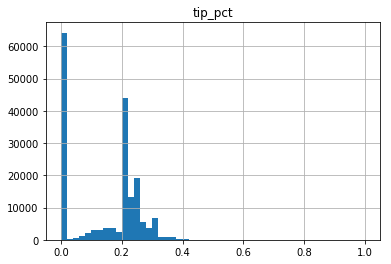

In [7]:
# Calculate the tip_pct
df_filtered['tip_pct'] = df_filtered['tip_amount']/df_filtered['fare_amount']
df_filtered = df_filtered[df_filtered['tip_pct'] <= 1].copy()
df_filtered['tip_pct'].hist(bins=50)
plt.title('tip_pct');

# Intuition
- Intuitively, the absolute value of tip_pct maybe very hard to predict without details about the individual's financial status
- However, from the above distribution, it looks like majority of the tip_pct are clustered around 2 values (0 and 0.2).
- Could it be possible to predict whether a trip can result in low tip_pct of high_tip percentage?

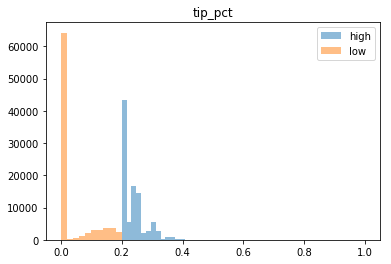

In [8]:
# From the distribution, looks like tip_pct is obviously split into 2 classes. Manually encode the tip_pct as 'high' if tip_pct is >0.2, or 'low' otherwise
df_filtered['tip_class'] = np.where(df_filtered['tip_pct']>=0.2, 'high', 'low')
labels = ['high', 'low']
plt.hist(df_filtered['tip_pct'].loc[df_filtered['tip_class'] == 'high'], bins=50, alpha=0.5, label='high')
plt.hist(df_filtered['tip_pct'].loc[df_filtered['tip_class'] == 'low'], bins=10, alpha=0.5, label='low')
plt.legend(loc='upper right')
plt.title('tip_pct')
plt.show()

In [9]:
# Check the distribution between the 2 tip_pct classes
#df_filtered['tip_class'].hist()
#plt.title('tip_class');

### Create new features as mentioned in [02_Fare Prediction.ipynb](https://github.com/stephenleo87/nyc-taxi/blob/master/02_Fare%20Prediction.ipynb)

In [10]:
df_filtered['pickup_datetime'] = pd.to_datetime(df_filtered['pickup_datetime'])
df_filtered['dropoff_datetime'] = pd.to_datetime(df_filtered['dropoff_datetime'])
df_filtered['trip_duration'] = (df_filtered['dropoff_datetime']-df_filtered['pickup_datetime']).dt.total_seconds()/60
df_filtered['year'] = df_filtered['pickup_datetime'].dt.year
df_filtered['day'] = df_filtered['pickup_datetime'].dt.day
df_filtered['month'] = df_filtered['pickup_datetime'].dt.month
df_filtered['day_of_week'] = df_filtered['pickup_datetime'].dt.weekday_name
df_filtered['hour_of_day'] = df_filtered['pickup_datetime'].dt.hour
df_filtered['lat_dif'] = df_filtered['pickup_latitude'] - df_filtered['dropoff_latitude']
df_filtered['lon_dif'] = df_filtered['pickup_longitude'] - df_filtered['dropoff_longitude']
df_filtered['pickup_geohash']=df_filtered.apply(lambda x: gh.encode(x.pickup_latitude, x.pickup_longitude, precision=5), axis=1)
df_filtered['dropoff_geohash']=df_filtered.apply(lambda x: gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision=5), axis=1)

df_filtered.head()

,Unnamed: 0,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,...,trip_duration,year,day,month,day_of_week,hour_of_day,lat_dif,lon_dif,pickup_geohash,dropoff_geohash
0,0,2,2015-07-18 11:25:58,2015-07-18 11:43:47,1,7.21,-73.862762,40.769028,1.0,N,...,17.816667,2015,18,7,Saturday,11,0.046444,0.086441,dr5rz,dr5rt
1,1,1,2015-03-15 12:50:01,2015-03-15 13:23:35,1,10.80,-73.870926,40.773727,NaN,N,...,33.566667,2015,15,3,Sunday,12,0.008034,0.117302,dr5rz,dr5ru
2,2,2,2015-04-30 12:25:44,2015-04-30 13:03:51,1,4.28,-73.978180,40.762341,NaN,N,...,38.116667,2015,30,4,Thursday,12,0.051552,0.030731,dr5ru,dr5re
3,3,2,2015-05-28 08:47:56,2015-05-28 09:26:08,1,18.47,-73.776711,40.645302,NaN,N,...,38.200000,2015,28,5,Thursday,8,-0.207550,0.066711,dr5x1,dr72r
4,4,1,2015-06-20 19:36:17,2015-06-20 20:10:49,1,15.50,-73.777054,40.644947,NaN,Y,...,34.533333,2015,20,6,Saturday,19,-0.080074,0.169746,dr5x1,dr5rt


In [11]:
df_filtered.shape

(179682, 32)

In [12]:
# Remove null values from lattitude and longitude
df_filtered = df_filtered[df_filtered['lat_dif'].notnull() & df_filtered['lon_dif'].notnull()].copy()
df_filtered.shape

(135875, 32)

In [13]:
# View some stats of unused columns to see if they can be added into the model
df_filtered[['extra', 'mta_tax', 'tolls_amount', 'imp_surcharge']].describe()

,extra,mta_tax,tolls_amount,imp_surcharge
count,135875.000000,135875.000000,135875.000000,135875.000000
mean,0.326837,0.487411,2.068308,0.298918
std,0.353868,0.078332,3.896060,0.017983
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.500000,0.000000,0.300000
50%,0.500000,0.500000,0.000000,0.300000
75%,0.500000,0.500000,5.540000,0.300000
max,3.500000,0.500000,661.580000,0.300000


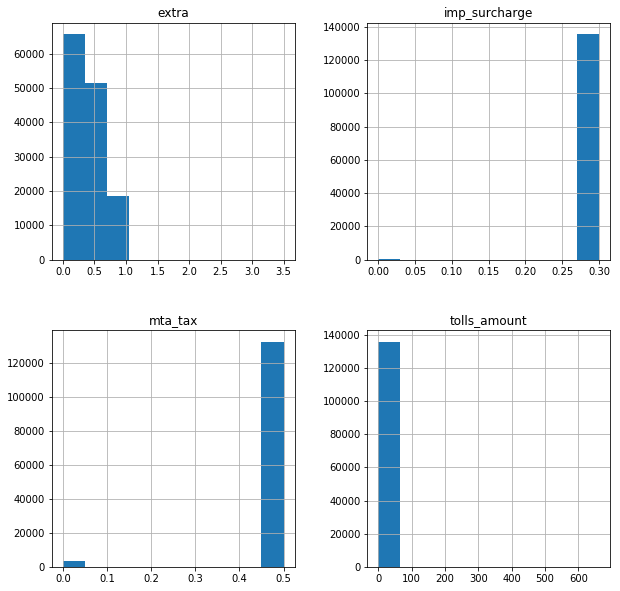

In [14]:
df_filtered[['extra', 'mta_tax', 'tolls_amount', 'imp_surcharge']].hist(figsize = (10,10));

C:\Users\msleo\anaconda2\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


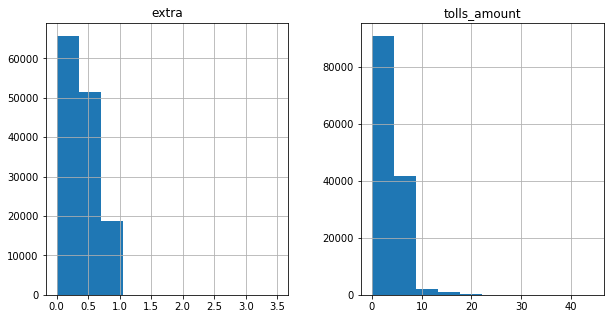

In [15]:
# mta_tax and imp_surchage seems constant so they probably dont add any additional info
# Remove the outlier on tolls_amount
df_filtered = df_filtered[df['tolls_amount'] <= 50].copy()
df_filtered[['extra', 'tolls_amount']].hist(figsize = (10,5));

In [16]:
# Define some helper functions
def train_test_split(X, y):
    """Split X and y into training set and testing set.
    Data from year = 2015 is used as training set while data from year = 2016 is used as testing set.
    Returns X_train, y_train, X_test, y_test
    """
    
    X_train = X.loc[X['year'] == 2015].drop('year', axis=1)
    y_train = y.loc[y['year'] == 2015].drop('year', axis=1).values.ravel()
    X_test = X.loc[X['year'] == 2016].drop('year', axis=1)
    y_test = y.loc[y['year'] == 2016].drop('year', axis=1).values.ravel()
    return X_train, y_train, X_test, y_test

def model_results(X_train, y_train, X_test, y_test, model, model_name):
    """Print model parameters of Accuracy and AUC on training and testing sets.
    """
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train = [1 if x == 'high' else 0 for x in y_train]
    y_test = [1 if x == 'high' else 0 for x in y_test]
    y_train_pred = [1 if x == 'high' else 0 for x in y_train_pred]
    y_test_pred = [1 if x == 'high' else 0 for x in y_test_pred]
    print("----{} Training Data results (2015 data set)----".format(model_name))
    print("Accuracy: {:.2f}".format(accuracy_score(y_train,y_train_pred)))
    print("AUC: {:.2f}\n".format(roc_auc_score(y_train,y_train_pred)))
    
    print("----{} Test Data results (2016 data set)----".format(model_name))
    print("Accuracy: {:.2f}".format(accuracy_score(y_test,y_test_pred)))
    print("AUC: {:.2f}\n\n".format(roc_auc_score(y_test,y_test_pred)))

In [17]:
# Split response (y) and features (X)
y = df_filtered[['tip_class', 'year']]
X = df_filtered[['passenger_count', 'trip_distance', 'fare_amount', 'trip_duration', 'year', 'month', 'day_of_week', 'hour_of_day', 'lat_dif', 'lon_dif', 'pickup_geohash', 'extra', 'tolls_amount']]
X_encoded = pd.get_dummies(X, columns=['month', 'day_of_week', 'hour_of_day', 'pickup_geohash'])

In [18]:
# Split Training and Testing sets
X_train, y_train, X_test, y_test = train_test_split(X_encoded, y)

In [19]:
# Check distribution of classes on training and testing sets
# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
# plt.hist(y_train)
# plt.title('y_train')
# plt.subplot(1,2,2)
# plt.hist(y_test)
# plt.title('y_test');

In [20]:
# Create a helper function
def model_comparison(X_train, y_train, X_test, y_test):
    """Compare several classic classifiers by fitting a model on X_train, y_train 
    and compare accuracy on y_test vs y_pred
    """
    
    #LOGISTIC REGRESSION
    lr_model = LogisticRegression(solver = 'saga')
    lr_model.fit(X_train,y_train)
    model_results(X_train, y_train, X_test, y_test, lr_model, 'Logistic Regression')

    #SVC
    svc_model = SVC(gamma = 'auto')
    svc_model.fit(X_train,y_train)
    model_results(X_train, y_train, X_test, y_test, svc_model, 'SVC')

    #NAIVE BAYES
    nb_model = GaussianNB()
    nb_model.fit(X_train,y_train)
    model_results(X_train, y_train, X_test, y_test, nb_model, 'Naive Bayes')

    #KNN
    knn_model = KNeighborsClassifier()
    knn_model.fit(X_train,y_train)
    model_results(X_train, y_train, X_test, y_test, knn_model, 'KNN')

    #DECISON TREE
    dtree_model = DecisionTreeClassifier()
    dtree_model.fit(X_train,y_train)
    model_results(X_train, y_train, X_test, y_test, dtree_model, 'Decision Tree')

    #RANDOM FOREST
    rfc_model = ensemble.RandomForestClassifier(n_estimators = 500, max_depth = 4)
    rfc_model.fit(X_train,y_train)
    model_results(X_train, y_train, X_test, y_test, rfc_model, 'Random Forest')

    #GRADIENT BOOSTING
    gbc_model = ensemble.GradientBoostingClassifier(n_estimators = 500, max_depth = 4)
    gbc_model.fit(X_train,y_train)
    model_results(X_train, y_train, X_test, y_test, gbc_model, 'Gradient Boosting')
    
    #NEURAL NET
    nn_model = MLPClassifier(alpha=1, max_iter=1000)
    nn_model.fit(X_train,y_train)
    model_results(X_train, y_train, X_test, y_test, nn_model, 'Neural Net')

In [21]:
model_comparison(X_train, y_train, X_test, y_test)

C:\Users\msleo\anaconda2\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


----Logistic Regression Training Data results (2015 data set)----
Accuracy: 0.51
AUC: 0.50

----Logistic Regression Test Data results (2016 data set)----
Accuracy: 0.57
AUC: 0.50


----SVC Training Data results (2015 data set)----
Accuracy: 0.59
AUC: 0.59

----SVC Test Data results (2016 data set)----
Accuracy: 0.56
AUC: 0.58


----Naive Bayes Training Data results (2015 data set)----
Accuracy: 0.51
AUC: 0.51

----Naive Bayes Test Data results (2016 data set)----
Accuracy: 0.57
AUC: 0.51


----KNN Training Data results (2015 data set)----
Accuracy: 0.71
AUC: 0.71

----KNN Test Data results (2016 data set)----
Accuracy: 0.55
AUC: 0.55


----Decision Tree Training Data results (2015 data set)----
Accuracy: 1.00
AUC: 1.00

----Decision Tree Test Data results (2016 data set)----
Accuracy: 0.54
AUC: 0.54


----Random Forest Training Data results (2015 data set)----
Accuracy: 0.59
AUC: 0.59

----Random Forest Test Data results (2016 data set)----
Accuracy: 0.57
AUC: 0.58


----Gradient Boost

# Data Augmentation
- Could it be possible that weather plays a role in making passengers more generous to tip higher?

In [22]:
weather_df = pd.read_csv('weather_data.csv')
weather_df.head()

,Unnamed: 0,year,month,day,min_temp,max_temp,prcp,sndp
0,0,2016,4,3,35.1,61.0,0.24,999.9
1,1,2016,3,21,33.1,50.0,0.14,999.9
2,2,2016,8,5,70.0,86.0,0.00,999.9
3,3,2016,10,31,46.9,60.1,0.76,999.9
4,4,2016,3,25,44.1,73.0,0.00,999.9


In [23]:
df_augmented = df_filtered.merge(weather_df, how='inner', on = ['year', 'month', 'day'])
print(df_augmented.shape)
df_augmented.head()

(135867, 37)


,Unnamed: 0_x,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,...,hour_of_day,lat_dif,lon_dif,pickup_geohash,dropoff_geohash,Unnamed: 0_y,min_temp,max_temp,prcp,sndp
0,0,2,2015-07-18 11:25:58,2015-07-18 11:43:47,1,7.21,-73.862762,40.769028,1.0,N,...,11,0.046444,0.086441,dr5rz,dr5rt,696,68.0,86.0,0.0,999.9
1,1015,1,2015-07-18 05:45:28,2015-07-18 06:10:13,1,14.00,-74.011505,40.702785,1.0,N,...,5,0.103264,0.077049,dr5re,dr5qf,696,68.0,86.0,0.0,999.9
2,1425,1,2015-07-18 00:22:24,2015-07-18 00:50:07,1,6.10,-74.008011,40.741375,1.0,N,...,0,-0.062584,-0.044930,dr5rg,dr72h,696,68.0,86.0,0.0,999.9
3,3924,1,2015-07-18 21:58:53,2015-07-18 22:16:51,1,7.50,-73.970001,40.785599,1.0,N,...,21,-0.071918,-0.036736,dr72h,dr72m,696,68.0,86.0,0.0,999.9
4,4093,1,2015-07-18 11:19:37,2015-07-18 11:46:54,2,10.00,-73.862732,40.769016,1.0,N,...,11,0.047882,0.124977,dr5rz,dr5rs,696,68.0,86.0,0.0,999.9


In [24]:
y = df_augmented[['tip_class', 'year']]
X = df_augmented[['passenger_count', 'trip_distance', 'fare_amount', 'trip_duration', 'year', 'month', 'day_of_week', 'hour_of_day', 'lat_dif', 'lon_dif', 'pickup_geohash', 'extra', 'tolls_amount',\
                 'min_temp', 'max_temp', 'prcp', 'sndp']]
X_encoded = pd.get_dummies(X, columns=['month', 'day_of_week', 'hour_of_day', 'pickup_geohash'])
X_train_aug, y_train_aug, X_test_aug, y_test_aug = train_test_split(X_encoded, y)

In [25]:
model_comparison(X_train_aug, y_train_aug, X_test_aug, y_test_aug)

----Logistic Regression Training Data results (2015 data set)----
Accuracy: 0.51
AUC: 0.51

----Logistic Regression Test Data results (2016 data set)----
Accuracy: 0.56
AUC: 0.50


----SVC Training Data results (2015 data set)----
Accuracy: 0.59
AUC: 0.59

----SVC Test Data results (2016 data set)----
Accuracy: 0.55
AUC: 0.57


----Naive Bayes Training Data results (2015 data set)----
Accuracy: 0.54
AUC: 0.54

----Naive Bayes Test Data results (2016 data set)----
Accuracy: 0.59
AUC: 0.54


----KNN Training Data results (2015 data set)----
Accuracy: 0.70
AUC: 0.70

----KNN Test Data results (2016 data set)----
Accuracy: 0.53
AUC: 0.53


----Decision Tree Training Data results (2015 data set)----
Accuracy: 1.00
AUC: 1.00

----Decision Tree Test Data results (2016 data set)----
Accuracy: 0.54
AUC: 0.54


----Random Forest Training Data results (2015 data set)----
Accuracy: 0.59
AUC: 0.59

----Random Forest Test Data results (2016 data set)----
Accuracy: 0.57
AUC: 0.58


----Gradient Boost

# Conclusion
- All models have low predictive power with the best model only having 60% accuracy
- Possibly because the data set does not contain important information like passenger financial information that could determine whether a passenger tips a high percentage or not